#Preprocessing and Feature Engineering

## 🔧 Step 1: Import Libraries

We start by importing all necessary libraries for:

- Data handling: `pandas`, `numpy`
- Preprocessing and evaluation: `MinMaxScaler`, `mean_squared_error`
- Deep learning: layers from `Keras` (LSTM, Conv1D, etc.), model setup, optimizers
- Callbacks: `EarlyStopping` to prevent overfitting
- Regularization: `l2`
- Utility: date/time functions and randomization


In [30]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import (Dense, LSTM, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization, Layer,
                        Bidirectional, MultiHeadAttention, LayerNormalization, Lambda)
from keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

from datetime import datetime, timedelta, time

import random

## 📥 Step 2: Download Bitcoin Price Data

We use `yfinance` to fetch historical Bitcoin (`BTC-USD`) price data from Yahoo Finance starting from 2014.  
We then clean up the dataset:
- Reset the index
- Rename columns (`Close` → `price`, etc.)
- Make a copy of the original data for future reference


In [31]:
import yfinance as yf

# Fetch Bitcoin data
data = yf.download('BTC-USD', start='2014-01-01', end=pd.Timestamp.today())

data = data.reset_index()  # Make Date a regular column
data.columns = data.columns.droplevel(1)  # Remove the Ticker level from column
data = data.rename(columns={'Close':'price', 'Date':'date', 'Volume':'volume'})  # Rename Price
btc_original = data.copy()


/tmp/ipython-input-31-3993175372.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download('BTC-USD', start='2014-01-01', end=pd.Timestamp.today())
[*********************100%***********************]  1 of 1 completed


## ⚙️ Step 3: Feature Engineering

We add several technical indicators and price-based features to improve the predictive power of our model:

- **RSI (Relative Strength Index)**: Measures recent gains vs. losses to indicate market momentum.
- **MACD (Moving Average Convergence Divergence)**: Identifies shifts in trend direction.
- **OBV (On-Balance Volume)**: Combines price movement and volume to detect strength behind price trends.
- **Daily Return**: Percent change in price from the previous day.
- **7-Day Moving Average (MA7)**: Smooths short-term price fluctuations.
- **MA7 Percentage Difference**: Measures how far the current price deviates from its 7-day moving average.

We also drop missing values that result from rolling window calculations.


In [32]:
# RSI
def compute_rsi(series, window=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

# MACD
def compute_macd(series, slow=26, fast=12, signal=9):
    exp1 = series.ewm(span=fast, adjust=False).mean()
    exp2 = series.ewm(span=slow, adjust=False).mean()
    macd = exp1 - exp2
    signal_line = macd.ewm(span=signal, adjust=False).mean()
    return macd - signal_line

# OBV
def calculate_obv(df):
    obv = [0]
    for i in range(1, len(df)):
        if df['price'].iloc[i] > df['price'].iloc[i-1]:
            obv.append(obv[-1] + df['volume'].iloc[i])
        elif df['price'].iloc[i] < df['price'].iloc[i-1]:
            obv.append(obv[-1] - df['volume'].iloc[i])
        else:
            obv.append(obv[-1])
    df['obv'] = obv
    return df

In [33]:
  # === Apply all feature engineering ===
  data = calculate_obv(data)  # OBV
  data['rsi'] = compute_rsi(data['price'])  # RSI
  data['macd'] = compute_macd(data['price'])  # MACD
  data['daily_prt'] = data['price'].pct_change()  # Daily % return
  data['ma7'] = data['price'].rolling(window=7).mean()  # 7-day MA
  data['ma7_prt'] = (data['price'] - data['ma7']) / data['ma7']  # MA7 %
  data['date'] = data['date'].apply(lambda x : pd.to_datetime(x.date()))

data['date'] = pd.to_datetime(data['date'])  # Ensure datetime format
data = data.dropna()                         # Drop NaNs from rolling features
data.info()                                  # Print dataset summary
data.head()


<class 'pandas.core.frame.DataFrame'>
Index: 3937 entries, 13 to 3949
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       3937 non-null   datetime64[ns]
 1   price      3937 non-null   float64       
 2   High       3937 non-null   float64       
 3   Low        3937 non-null   float64       
 4   Open       3937 non-null   float64       
 5   volume     3937 non-null   int64         
 6   obv        3937 non-null   int64         
 7   rsi        3937 non-null   float64       
 8   macd       3937 non-null   float64       
 9   daily_prt  3937 non-null   float64       
 10  ma7        3937 non-null   float64       
 11  ma7_prt    3937 non-null   float64       
dtypes: datetime64[ns](1), float64(9), int64(2)
memory usage: 399.9 KB


Price,date,price,High,Low,Open,volume,obv,rsi,macd,daily_prt,ma7,ma7_prt
13,2014-09-30,386.944000,390.976990,373.442993,376.088013,34707300,-108228200,31.997433,-4.045043,0.030567,396.902283,-0.025090
14,2014-10-01,383.614990,391.378998,380.779999,387.427002,26229400,-134457600,31.461697,-3.461881,-0.008603,391.246569,-0.019506
15,2014-10-02,375.071991,385.497009,372.946014,383.988007,21777700,-156235300,35.852649,-3.327604,-0.022270,386.031996,-0.028391
16,2014-10-03,359.511993,377.695007,357.859009,375.181000,30901200,-187136500,39.000831,-3.921943,-0.041485,379.615853,-0.052958
17,2014-10-04,328.865997,364.487000,325.885986,359.891998,47236500,-234373000,27.381697,-5.895622,-0.085243,369.522426,-0.110024


## 🔗 Step 4: Add On-Chain Metrics (Difficulty & Hash Rate)

We fetch two important blockchain-level indicators from the Blockchain.com API:

- **Difficulty**: Reflects how hard it is to mine a new Bitcoin block. A higher value typically indicates increased network competition and security.
- **Hash Rate**: Measures the total computational power used for mining. A rising hash rate often suggests miner confidence and a healthy network.

.


In [34]:
import requests
from io import StringIO

# BTC On-Chain Metrics
url_diff = 'https://api.blockchain.info/charts/difficulty?timespan=all&rollingAverage=1days&start=2010-01-01&format=json'
url_hash = 'https://api.blockchain.info/charts/hash-rate?timespan=all&rollingAverage=1days&start=2010-01-01&format=json'

def get_chain_metrics(url, column_name):
    response = requests.get(url)
    chain_m = []

    if response.status_code == 200:
        data = response.json()
        chain_m = pd.DataFrame(data['values']).copy()

        # Convert and format columns
        chain_m['date'] = pd.to_datetime(chain_m['x'], unit='s')
        chain_m = chain_m[['x', 'y', 'date']].rename(columns={
            'x': 'time_sec',
            'y': column_name
        })

        # Fill missing daily values
        chain_m.set_index('time_sec', inplace=True)
        current_timestamp = datetime.now().replace(hour=0, minute=0, second=0, microsecond=0).timestamp()
        day_offset = int(current_timestamp) - chain_m.index.max()

        full_index = pd.RangeIndex(start=chain_m.index.min(), stop=chain_m.index.max() + 1, step=86400)
        chain_m = chain_m.reindex(full_index)
        chain_m[column_name] = chain_m[column_name].interpolate(method='linear')

        # Realign dates so last point matches today
        chain_m['date'] = pd.to_datetime(chain_m.index + day_offset, unit='s')
        chain_m['date'] = chain_m['date'].apply(lambda x: pd.to_datetime(x.date()))

        chain_m.reset_index(inplace=True)
        chain_m.rename(columns={'index': 'time_sec'}, inplace=True)
        chain_m = chain_m.drop(columns=['time_sec'])

        print(chain_m.head(10))
        return chain_m
    else:
        print(f"Error: {response.status_code}")

# Fetch and process on-chain metrics and dropping rows with null values
diff_df = get_chain_metrics(url_diff, 'difficulty')
hash_df = get_chain_metrics(url_hash, 'hash_rate')


data = data.merge(diff_df, on='date', how='outer')  #merge
data = data.merge(hash_df, on='date', how='outer')

data = data.dropna()

   difficulty       date
0     1.18290 2010-01-06
1     1.18290 2010-01-07
2     1.18290 2010-01-08
3     1.18290 2010-01-09
4     1.18290 2010-01-10
5     1.18290 2010-01-11
6     1.18290 2010-01-12
7     1.18290 2010-01-13
8     1.18290 2010-01-14
9     1.21344 2010-01-15
   hash_rate       date
0   0.000008 2010-01-06
1   0.000008 2010-01-07
2   0.000008 2010-01-08
3   0.000009 2010-01-09
4   0.000009 2010-01-10
5   0.000010 2010-01-11
6   0.000010 2010-01-12
7   0.000011 2010-01-13
8   0.000011 2010-01-14
9   0.000011 2010-01-15


## 😨 Step 5: Add Fear & Greed Index

We fetch the **Fear & Greed Index** from [alternative.me](https://alternative.me/crypto/fear-and-greed-index/), a popular market sentiment indicator for crypto.

- **fng_value**: A score between 0 (extreme fear) and 100 (extreme greed)
- **classification**: The human-readable label (e.g., "Fear", "Greed")

Steps:
1. Request all historical index values using their API
2. Parse and reformat the response to match our `date` format
3. Merge the index data with our main dataset
4. Drop any rows with missing values post-merge to ensure data consistency


In [35]:
# === Fear and Greed Index ===
import requests
from io import StringIO

# Source: https://alternative.me/crypto/fear-and-greed-index/
url = 'https://api.alternative.me/fng/?limit=0'
response = requests.get(url)

if response.status_code == 200:
    data_r = response.json()
    df_response = pd.DataFrame(data_r['data'])

    # Format columns
    df_response['date'] = pd.to_datetime(df_response['timestamp'], unit='s')
    df_response = df_response[['value', 'value_classification', 'date']] \
        .rename(columns={
            'value': 'fng_value',
            'value_classification': 'classification'
        })

    # Convert index value to float
    df_response['fng_value'] = df_response['fng_value'].astype(float)
    fng_df = df_response.copy()

    # Merge with main data
    data = data.merge(fng_df, on='date', how='outer')
    data = data.dropna()  # remove rows with any missing values after merge

    print(data.head(10))  # quick sanity check

else:
    print(f"Error fetching Fear & Greed Index: {response.status_code}")


           date        price          High          Low          Open  \
1220 2018-02-01  9170.540039  10288.799805  8812.280273  10237.299805   
1221 2018-02-02  8830.750000   9142.280273  7796.490234   9142.280273   
1222 2018-02-03  9174.910156   9430.750000  8251.629883   8852.120117   
1223 2018-02-04  8277.009766   9334.870117  8031.220215   9175.700195   
1224 2018-02-05  6955.270020   8364.839844  6756.680176   8270.540039   
1225 2018-02-06  7754.000000   7850.700195  6048.259766   7051.750000   
1226 2018-02-07  7621.299805   8509.110352  7236.790039   7755.490234   
1227 2018-02-08  8265.589844   8558.769531  7637.859863   7637.859863   
1228 2018-02-09  8736.980469   8736.980469  7884.709961   8271.839844   
1229 2018-02-10  8621.900391   9122.549805  8295.469727   8720.080078   

            volume           obv        rsi        macd  daily_prt  \
1220  9.959400e+09  1.237985e+11  34.828472 -129.294851  -0.102783   
1221  1.272690e+10  1.110716e+11  32.204720 -177.439771 

/tmp/ipython-input-35-3052447857.py:14: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df_response['date'] = pd.to_datetime(df_response['timestamp'], unit='s')


##🧠 Step 6: Prepare Data for Time Series Prediction

To build a supervised learning model that uses past patterns to predict future movement, we:

1. **Select Features & Target**:
   - Features include technical indicators, on-chain metrics, and sentiment signals
   - The target is `ma7_prt`, which tells us how far the current price deviates from its 7-day moving average

2. **Normalize Features**:
   - Each feature is scaled independently to the range [0, 1] using `MinMaxScaler`
   - This ensures equal contribution to learning and faster convergence

3. **Create Time Series Sequences**:
   - We use a `look_back` window of **60 days** (~3 months) to form the input sequence
   - For every data point after the 60th day, we use the previous 60 days to form `X`, and the current `ma7_prt` as `y`
   - Final input shape:  
     `X.shape = (samples, 60, number of features)`  
     `y.shape = (samples,)`

This prepares the data for input into a sequence model like CNN-LSTM.


In [36]:
from sklearn.preprocessing import MinMaxScaler

# === Feature & target selection ===
features = [
    'price', 'rsi', 'macd', 'volume', 'obv', 'fng_value',
    'daily_prt', 'difficulty', 'hash_rate',
    'ma7', 'ma7_prt'
]
target = 'ma7_prt'

# Extract data and normalize features individually
filtered_data = data[features].values

scalers = {}
for i in range(len(features)):
    scaler = MinMaxScaler(feature_range=(0, 1))
    filtered_data[:, i:i+1] = scaler.fit_transform(filtered_data[:, i:i+1])
    scalers[features[i]] = scaler

# Prepare look-back sequences for supervised learning
look_back = 60  # number of past days to look at
target_index = features.index(target)

X, y = [], []
for i in range(look_back, len(data)):
    X.append(filtered_data[i-look_back:i, :])
    y.append(filtered_data[i, target_index])

X, y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], len(features)))  # reshape for CNN-LSTM input


In [37]:
filtered_data.shape

(2713, 11)

#Model Design and Implementation

## 🧠 Model Architecture: CNN-LSTM Hybrid

We build a hybrid model to capture both short-term patterns (via CNN) and long-term dependencies (via LSTM):

- **Conv1D layers** extract local temporal patterns from input sequences
- **MaxPooling + BatchNorm + Dropout** help reduce overfitting
- **LSTM layers** learn long-range sequential relationships
- **Dense layer with `tanh`** acts as a soft attention mechanism
- The final layer outputs a single continuous value (our prediction)

We compile the model with the Adam optimizer and use Mean Squared Error (MSE) as the loss function.


In [10]:
import keras

In [11]:
keras.utils.set_random_seed(114)

# Create CNN-LSTM model
model = Sequential()

# CNN layers for pattern extraction
model.add(Conv1D(filters=256, kernel_size=2, activation='relu', input_shape=(look_back, len(features))))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=256, kernel_size=1, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# LSTM layers for temporal dependencies
model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=50))
model.add(Dropout(0.2))

# Attention-like Dense layer (context learning)
model.add(Dense(units=100, activation='tanh'))
model.add(Dropout(0.3))

# Output layers
model.add(Dense(units=50, activation='relu'))
model.add(Dense(units=1))  # Final prediction

# Compile
model.compile(optimizer=Adam(learning_rate=0.0035), loss='mean_squared_error')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [48]:
test_size = 0.05  # Use last 5% of data for testing

# Split into train and test sets
split = int(len(X) * (1 - test_size))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


## 🚀 Training the Model

We train the CNN-LSTM model for up to 200 epochs, using:

- **EarlyStopping**: Monitors validation loss and restores the best weights if no improvement for 40 epochs
- **Batch Size**: 32 samples per batch

This helps prevent overfitting and ensures optimal model performance on unseen data.


In [39]:
epochs = 200
batch_size = 32

early_stop = EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True, verbose=1)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test, y_test),
    #callbacks=[early_stop],
    verbose=1
)


Epoch 1/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - loss: 0.0899 - val_loss: 0.0029
Epoch 2/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 0.0086 - val_loss: 0.0029
Epoch 3/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - loss: 0.0082 - val_loss: 0.0023
Epoch 4/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 0.0079 - val_loss: 0.0024
Epoch 5/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.0077 - val_loss: 0.0032
Epoch 6/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - loss: 0.0075 - val_loss: 0.0028
Epoch 7/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - loss: 0.0075 - val_loss: 0.0044
Epoch 8/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - loss: 0.0069 - val_loss: 0.0022
Epoch 9/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.0069 - val_loss: 0.0032
Epoch 10/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - loss: 0.0066 - val_loss: 0.0025
Epoch 11/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - loss: 0.0061 - val_loss: 0.0023
Epoch 12/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step

# Evaluation and Visualization


## 🔁 Step 1: Inverse Transform Predictions & Actuals

After making predictions using the CNN-LSTM model, we convert all values back to their **original (unscaled) units** for interpretation.

- We define a helper function `inverse_scaler()` that:
  1. Reconstructs a dummy array with all features
  2. Places the scaled target column (`ma7_prt`) into its correct position
  3. Applies inverse transformation using the saved scalers
  4. Returns only the unscaled target column

This prepares our predictions and labels for **real-world evaluation** (MSE, MAE, visualization).


In [49]:
# === Make Predictions ===
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# === Inverse Scaling Function ===
def inverse_scaler(scaled_data, features, scalers):
    """
    Reverse MinMax scaling for target column using saved scalers.
    """
    dummy_array = np.zeros((len(scaled_data), len(features)))
    dummy_array[:, target_index] = scaled_data.flatten()

    for i in range(len(features)):
        dummy_array[:, i] = scalers[features[i]].inverse_transform(
            dummy_array[:, i].reshape(-1, 1)
        ).flatten()

    return dummy_array[:, target_index]

# === Inverse Transform Predictions and Actual Values ===
train_predict = inverse_scaler(train_predict, features, scalers)
test_predict = inverse_scaler(test_predict, features, scalers)
y_train = inverse_scaler(y_train, features, scalers)
y_test = inverse_scaler(y_test, features, scalers)


79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


## 📏 Step 1: Evaluation Metrics

We assess model performance using:

- **RMSE**: Measures average prediction error in the same unit as the target (`ma7_prt`)
- **Pearson Correlation Coefficient (r)**: Measures the strength of linear correlation between predicted and actual values

A lower RMSE and higher `r` (closer to 1) indicate a more accurate and aligned model.


In [50]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Calculate RMSE (Root Mean Squared Error)
train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))
test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))

print(f'Train RMSE: {train_rmse:.2f}')
print(f'Test RMSE: {test_rmse:.2f}')

# Calculate Pearson Correlation Coefficient
r_coef_train = np.corrcoef(y_train, train_predict)[0, 1]
r_coef_test = np.corrcoef(y_test, test_predict)[0, 1]

print(f"Train - Pearson correlation coefficient: {r_coef_train:.4f}")
print(f"Test - Pearson correlation coefficient: {r_coef_test:.4f}")


Train RMSE: 0.02
Test RMSE: 0.04
Train - Pearson correlation coefficient: 0.9336
Test - Pearson correlation coefficient: 0.0874


## 📊 Step 2: Visualize Predictions vs Actual

We visualize the model's predictions against actual price movement:

- **Black**: Actual price (`ma7_prt`)
- **Blue**: Training predictions
- **Red**: Testing predictions

This helps assess how closely the model tracks the price across time.


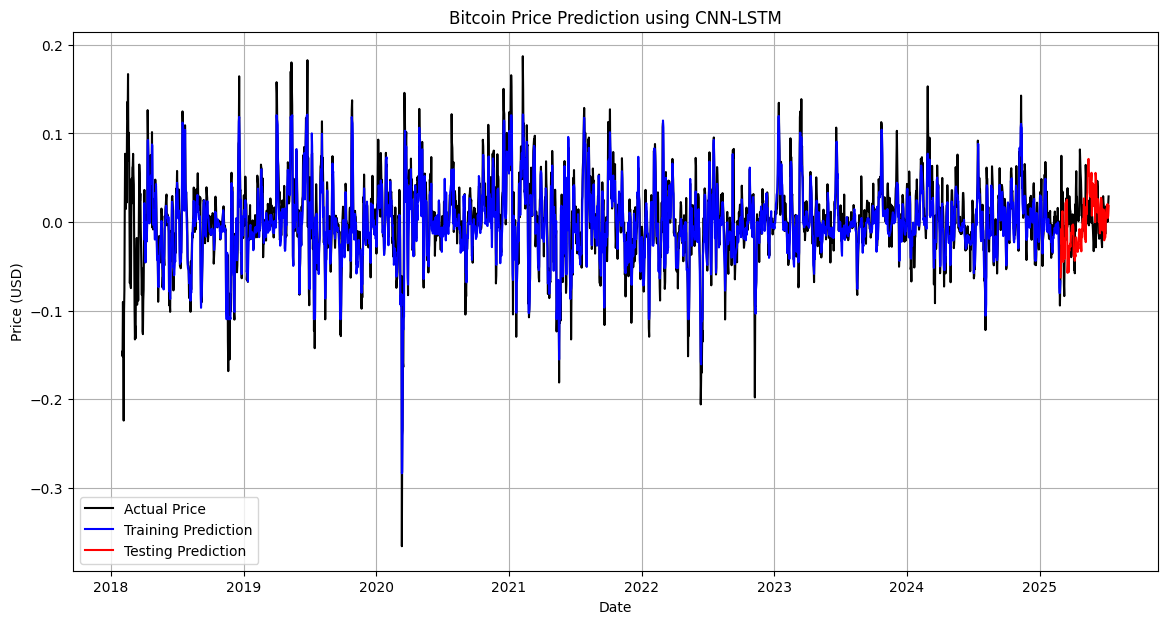

In [51]:
import matplotlib.pyplot as plt

# Plot predicted vs actual price (train & test)
plt.figure(figsize=(14, 7))

plt.plot(data['date'], data[target], label='Actual Price', color='black')
plt.plot(data[look_back:split + look_back]['date'], train_predict, label='Training Prediction', color='blue')
plt.plot(data[split + look_back:]['date'], test_predict, label='Testing Prediction', color='red')

plt.title('Bitcoin Price Prediction using CNN-LSTM')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()


#forcasting/prediction

## 🔁 Step 1: Rolling Forecasting

We generate predictions one day at a time:

1. Feed the last `look_back` sequence to the model
2. Predict the next day's **price return**
3. Convert return to absolute price using `(1 + return) * last_price`
4. Recompute technical indicators for the new point
5. Rescale and append it to the sequence for the next prediction

This loop simulates how predictions would work in a real-time rolling fashion.


In [52]:
data_future = data.copy()

# Prepare last look_back sequence
last_sequence = data.iloc[-look_back:].copy()
scaled_sequence = last_sequence.copy()

# Scale all features in the sequence
for i, column in enumerate(features):
    scaled_sequence[column] = scalers[column].transform(last_sequence[column].values.reshape(-1, 1))

current_sequence = scaled_sequence[features].values.copy()
predictions = []
days_to_predict = 60


In [53]:
for i in range(days_to_predict):
    # Predict next day's return
    x_input = current_sequence.reshape((1, look_back, len(features)))
    predicted_price_scaled = model.predict(x_input, verbose=1)

    # Inverse transform the predicted return
    predicted_price = scalers[target].inverse_transform(predicted_price_scaled)[0, 0]
    last_price = data_future.loc[data_future.index[-1], 'price']
    predictions.append((1 + predicted_price) * last_price)

    # Construct a new row with the predicted price
    predicted_row = {
        'price': (1 + predicted_price) * last_price,
        'rsi': 0, 'macd': 0, 'volume': 0, 'obv': 0,
        'fng_value': 0, 'difficulty': 0, 'hash_rate': 0,
        'ma7': 0, 'daily_prt': predicted_price
    }
    data_future.loc[len(data_future)] = predicted_row

    # Recalculate indicators for the new point
    data_future['rsi'] = compute_rsi(data_future['price'], window=14)
    data_future['macd'] = compute_macd(data_future['price'])
    data_future.loc[data_future.index[-1], 'volume'] = data_future['volume'].iloc[-1 + i] * random.uniform(-.02, 0.04)
    data_future = calculate_obv(data_future)
    data_future.loc[data_future.index[-1], 'fng_value'] = data_future['fng_value'].rolling(window=7).mean().iloc[-1]
    data_future.loc[data_future.index[-1], 'difficulty'] = data_future['difficulty'].iloc[-2] * 1.006
    data_future.loc[data_future.index[-1], 'hash_rate'] = data_future['hash_rate'].iloc[-2]
    data_future.loc[data_future.index[-1], 'ma5'] = data_future['price'].rolling(window=7).mean().iloc[-1]

    # Rescale the updated features for the next prediction
    new_row = current_sequence[-1].copy()
    new_row[1] = scalers['rsi'].transform([[data_future.loc[data_future.index[-1], 'rsi']]])[0][0]
    new_row[2] = scalers['macd'].transform([[data_future.loc[data_future.index[-1], 'macd']]])[0][0]
    new_row[3] = scalers['volume'].transform([[data_future.loc[data_future.index[-1], 'volume']]])[0][0]
    new_row[4] = scalers['obv'].transform([[data_future.loc[data_future.index[-1], 'obv']]])[0][0]
    new_row[5] = scalers['fng_value'].transform([[data_future.loc[data_future.index[-1], 'fng_value']]])[0][0]
    new_row[6] = scalers['difficulty'].transform([[data_future.loc[data_future.index[-1], 'difficulty']]])[0][0]
    new_row[7] = scalers['hash_rate'].transform([[data_future.loc[data_future.index[-1], 'hash_rate']]])[0][0]
    new_row[6] = scalers['ma7'].transform([[data_future.loc[data_future.index[-1], 'ma7']]])[0][0]
    new_row[7] = scalers['daily_prt'].transform([[data_future.loc[data_future.index[-1], 'daily_prt']]])[0][0]

    current_sequence = np.vstack([current_sequence[1:], new_row])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━

In [54]:
# Get last known date
last_date = pd.to_datetime(data.index[-1])  # Convert to pandas Timestamp
prediction_dates = [last_date + pd.Timedelta(days=i) for i in range(1, days_to_predict+1)]
last_date = data['date'][-1:]
last_date_timestamp = pd.to_datetime(last_date.values[0]).timestamp()
prediction_dates = [last_date_timestamp + 43200 + 86400 * i for i in range(1, days_to_predict+1)]
prediction_dates = [datetime.fromtimestamp(i).date() for i in prediction_dates]

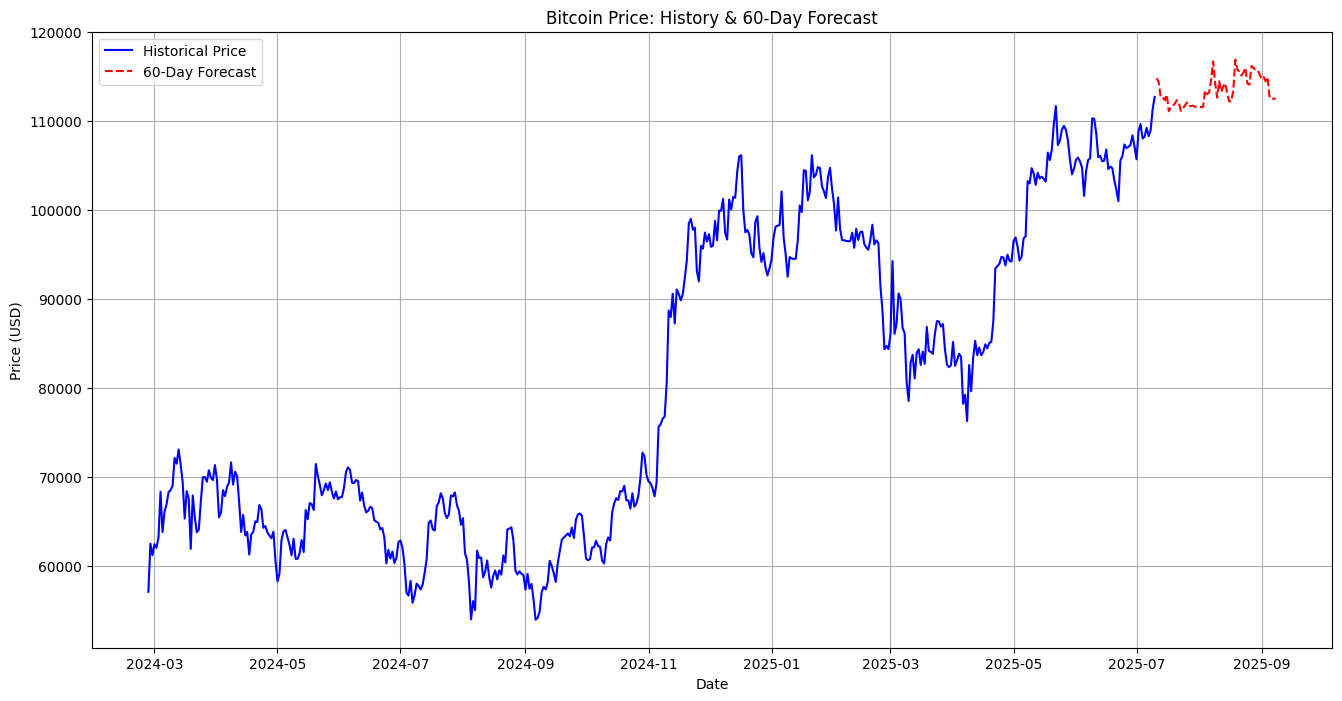


Predicted Bitcoin Prices for the Next 60 Days:
            Predicted_Price
Date                       
2025-07-11    114809.816199
2025-07-12    114348.307359
2025-07-13    112647.993246
2025-07-14    112668.072575
2025-07-15    112328.551202
2025-07-16    112953.583306
2025-07-17    111095.872510
2025-07-18    111526.184159
2025-07-19    111724.834493
2025-07-20    111935.287898


In [55]:
# Create DataFrame for predictions
future_df = pd.DataFrame({
    'Date': prediction_dates,
    'Predicted_Price': predictions
}).set_index('Date')

# Plot historical and predicted prices
plt.figure(figsize=(16, 8))
plt.plot(btc_original['date'][-500:], btc_original['price'][-500:], label='Historical Price', color='blue')
plt.plot(future_df.index, future_df['Predicted_Price'], label=f'{days_to_predict}-Day Forecast', color='red', linestyle='--')
plt.title(f'Bitcoin Price: History & {days_to_predict}-Day Forecast')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

# Print and export predictions
print("\nPredicted Bitcoin Prices for the Next 60 Days:")
print(future_df.head(10))

#saving the predicted result in csv

In [56]:
# Save to CSV
future_df = future_df.reset_index()[['Date', 'Predicted_Price']]
future_df.to_csv('lstm_cnn_btc_price.csv', index=False)